# **Load and Explore the Data**

In [ ]:
# Essential Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Men data**

In [ ]:
MRegular = pd.read_csv("MRegularSeasonDetailedResults.csv")
WRegular = pd.read_csv("WRegularSeasonDetailedResults.csv")
MTourney = pd.read_csv("MNCAATourneyDetailedResults.csv")
WTourney = pd.read_csv("WNCAATourneyDetailedResults.csv")
MSeeds = pd.read_csv("MNCAATourneySeeds.csv")
WSeeds = pd.read_csv("WNCAATourneySeeds.csv")

display(MRegular.head())
display(MTourney.head())
display(MSeeds.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


**Women data**

# **Feature Engineering**

##**1. Insights**

We need features that capture:

* **Team Strength**: Seeds, historical performance, advanced stats.
* **Matchup Dynamics**: Relative differences between teams.

We’ll create features like:

* **Winning percentage**: How often a team wins.
* **Average points scored**: Offensive strength.
* **Average points conceded**: Defensive strength.
* **Score Differential**: margin of victory between teams historically
* **Average Score Differential**: Average margin of victory per team historically
* **Tournament seeding**: Stronger teams are seeded higher.
* **Game statistics**: Rebounds, assists, turnovers, etc.
* **Elo Ratings**: dynamically rate teams based on past wins/losses (adjust ratings after each game).

Raw Features from Provided Files
1. **Tournament seeding** (from MNCAATourneySeeds.csv):
* Intuition: Higher seeds (lower numbers) win more often.
* Extract numeric seed (e.g., 01 from W01) and use as a proxy for strength.
2. **Score Differential** (from RegularSeason and TourneyResults):
* WScore - LScore: Average margin of victory per team historically.
3. **Winning Percentage**:
* Count wins (WTeamID) and losses (LTeamID) per season to compute Wins / (Wins + Losses).
4. **Game Stats** (e.g., WFGM, WStl):
* Field goals made, steals, rebounds, etc., averaged per team per season.
* Indicates offensive/defensive prowess.

##**2. Engineering the features**

**Let's standardize Column Names**

In [ ]:
# Standardize Column Names

Regular = pd.concat([MRegular, WRegular], ignore_index=True)
Tourney = pd.concat([MTourney, WTourney], ignore_index=True)
Seeds = pd.concat([MSeeds, WSeeds], ignore_index=True)

###**Extracting Seeds**

In [ ]:
Seeds["SeedNum"] = Seeds["Seed"].str.extract("(\d+)").astype(int)

Seeds = Seeds[['Season', 'TeamID', 'SeedNum']]

Seeds.head()

,Season,TeamID,SeedNum
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


###**Average Stats**

In [ ]:
Regular['ScoreDiff'] = Regular['WScore'] - Regular['LScore']

Regular.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreDiff
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,6


In [ ]:
# Compute Features
def compute_features(df):
    """Computes team statistics per season."""
    team_stats = df.groupby(["Season", "WTeamID"]).agg(
        Wins=("WTeamID", "count"),
        PointsScored=("WScore", "sum"),
        PointsAllowed=("LScore", "sum"),
        FGM=("WFGM", "sum"),
        FGA=("WFGA", "sum"),
        FG3M=("WFGM3", "sum"),
        FG3A=("WFGA3", "sum"),
        FTM=("WFTM", "sum"),
        FTA=("WFTA", "sum"),
        ORB=("WOR", "sum"),
        DRB=("WDR", "sum"),
        Assists=("WAst", "sum"),
        Turnovers=("WTO", "sum"),
        Steals=("WStl", "sum"),
        Blocks=("WBlk", "sum"),
        Fouls=("WPF", "sum")
    ).reset_index()

    # Compute Losses
    losses = df.groupby(["Season", "LTeamID"]).agg(
        Losses=("LTeamID", "count")
    ).reset_index()

    # Merge Wins & Losses
    team_stats = team_stats.merge(losses, left_on=["Season", "WTeamID"], right_on=["Season", "LTeamID"], how="left").fillna(0)
    team_stats.drop(columns=["LTeamID"], inplace=True)
    team_stats.rename(columns={"WTeamID": "TeamID"}, inplace=True)

    # Compute Derived Stats
    team_stats["GamesPlayed"] = team_stats["Wins"] + team_stats["Losses"]
    team_stats["WinRate"] = team_stats["Wins"] / team_stats["GamesPlayed"]
    team_stats["AvgPointsScored"] = team_stats["PointsScored"] / team_stats["GamesPlayed"]
    team_stats["AvgPointsAllowed"] = team_stats["PointsAllowed"] / team_stats["GamesPlayed"]
    team_stats["AvgPointDifferential"] = team_stats["AvgPointsScored"] - team_stats["AvgPointsAllowed"]

    return team_stats

In [ ]:
# Compute features for Regular Season & Tournament
reg_features = compute_features(Regular)
tourney_features = compute_features(Tourney)

reg_features.head()

,Season,TeamID,Wins,PointsScored,PointsAllowed,FGM,FGA,FG3M,FG3A,FTM,...,Turnovers,Steals,Blocks,Fouls,Losses,GamesPlayed,WinRate,AvgPointsScored,AvgPointsAllowed,AvgPointDifferential
0,2003,1102,12,825,638,271,480,120,259,163,...,133,88,34,193,16.0,28.0,0.428571,29.464286,22.785714,6.678571
1,2003,1103,13,1141,1019,390,720,71,187,290,...,163,95,24,266,14.0,27.0,0.481481,42.259259,37.740741,4.518519
2,2003,1104,17,1270,1046,439,992,120,354,272,...,222,123,71,280,11.0,28.0,0.607143,45.357143,37.357143,8.000000
3,2003,1105,7,556,465,179,433,64,157,134,...,126,79,14,136,19.0,26.0,0.269231,21.384615,17.884615,3.500000
4,2003,1106,13,888,753,322,700,76,207,168,...,230,122,49,239,15.0,28.0,0.464286,31.714286,26.892857,4.821429


In [ ]:
# Concatenate the features
features = pd.concat([reg_features, tourney_features], ignore_index=True)

features.head()

,Season,TeamID,Wins,PointsScored,PointsAllowed,FGM,FGA,FG3M,FG3A,FTM,...,Turnovers,Steals,Blocks,Fouls,Losses,GamesPlayed,WinRate,AvgPointsScored,AvgPointsAllowed,AvgPointDifferential
0,2003,1102,12,825,638,271,480,120,259,163,...,133,88,34,193,16.0,28.0,0.428571,29.464286,22.785714,6.678571
1,2003,1103,13,1141,1019,390,720,71,187,290,...,163,95,24,266,14.0,27.0,0.481481,42.259259,37.740741,4.518519
2,2003,1104,17,1270,1046,439,992,120,354,272,...,222,123,71,280,11.0,28.0,0.607143,45.357143,37.357143,8.000000
3,2003,1105,7,556,465,179,433,64,157,134,...,126,79,14,136,19.0,26.0,0.269231,21.384615,17.884615,3.500000
4,2003,1106,13,888,753,322,700,76,207,168,...,230,122,49,239,15.0,28.0,0.464286,31.714286,26.892857,4.821429


In [ ]:
# Merge with Seeds
features = features.merge(Seeds, on=["Season", "TeamID"], how="left").fillna(0)

features["SeedNum"] = features["SeedNum"].astype(int) # Ensure SeedNum is int
features.head()

,Season,TeamID,Wins,PointsScored,PointsAllowed,FGM,FGA,FG3M,FG3A,FTM,...,Steals,Blocks,Fouls,Losses,GamesPlayed,WinRate,AvgPointsScored,AvgPointsAllowed,AvgPointDifferential,SeedNum
0,2003,1102,12,825,638,271,480,120,259,163,...,88,34,193,16.0,28.0,0.428571,29.464286,22.785714,6.678571,0
1,2003,1103,13,1141,1019,390,720,71,187,290,...,95,24,266,14.0,27.0,0.481481,42.259259,37.740741,4.518519,0
2,2003,1104,17,1270,1046,439,992,120,354,272,...,123,71,280,11.0,28.0,0.607143,45.357143,37.357143,8.000000,10
3,2003,1105,7,556,465,179,433,64,157,134,...,79,14,136,19.0,26.0,0.269231,21.384615,17.884615,3.500000,0
4,2003,1106,13,888,753,322,700,76,207,168,...,122,49,239,15.0,28.0,0.464286,31.714286,26.892857,4.821429,0


###**Tournament Experience**

In [ ]:
# Compute Tournament Experience

tourney_wins = Tourney.groupby(['Season', 'WTeamID']).size().reset_index(name='TourneyWins')
tourney_losses = Tourney.groupby(['Season', 'LTeamID']).size().reset_index(name='TourneyLosses')

# Rename columns for merging
tourney_wins.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
tourney_losses.rename(columns={'LTeamID': 'TeamID'}, inplace=True)

# Merge wins and losses to calculate total games
tourney_games = tourney_wins.merge(tourney_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
tourney_games['TourneyGames'] = tourney_games['TourneyWins'] + tourney_games['TourneyLosses']

# Calculate win percentage
tourney_games['TourneyWinPct'] = tourney_games['TourneyWins'] / tourney_games['TourneyGames']

tourney_games.head()

,Season,TeamID,TourneyWins,TourneyLosses,TourneyGames,TourneyWinPct
0,2003,1104,0.0,1.0,1.0,0.000000
1,2003,1112,3.0,1.0,4.0,0.750000
2,2003,1113,1.0,1.0,2.0,0.500000
3,2003,1120,2.0,1.0,3.0,0.666667
4,2003,1122,0.0,1.0,1.0,0.000000


In [ ]:
# Merge Tournament Experience
features = features.merge(tourney_games, on = ['Season', 'TeamID'], how = 'left').fillna(0)
features.head()

,Season,TeamID,Wins,PointsScored,PointsAllowed,FGM,FGA,FG3M,FG3A,FTM,...,GamesPlayed,WinRate,AvgPointsScored,AvgPointsAllowed,AvgPointDifferential,SeedNum,TourneyWins,TourneyLosses,TourneyGames,TourneyWinPct
0,2003,1102,12,825,638,271,480,120,259,163,...,28.0,0.428571,29.464286,22.785714,6.678571,0,0.0,0.0,0.0,0.0
1,2003,1103,13,1141,1019,390,720,71,187,290,...,27.0,0.481481,42.259259,37.740741,4.518519,0,0.0,0.0,0.0,0.0
2,2003,1104,17,1270,1046,439,992,120,354,272,...,28.0,0.607143,45.357143,37.357143,8.000000,10,0.0,1.0,1.0,0.0
3,2003,1105,7,556,465,179,433,64,157,134,...,26.0,0.269231,21.384615,17.884615,3.500000,0,0.0,0.0,0.0,0.0
4,2003,1106,13,888,753,322,700,76,207,168,...,28.0,0.464286,31.714286,26.892857,4.821429,0,0.0,0.0,0.0,0.0


###**Elo Rating**

In [ ]:
# Compute Elo Rating
elo = {team: 1500 for team in features["TeamID"].unique()}
K = 32
for _, row in Regular.iterrows():
    team1, team2 = row["WTeamID"], row["LTeamID"]
    prob1 = 1 / (1 + 10 ** ((elo[team2] - elo[team1]) / 400))
    elo[team1] += K * (1 - prob1)
    elo[team2] += K * (0 - (1 - prob1))

# Convert Elo to DataFrame & Merge
elo_df = pd.DataFrame(list(elo.items()), columns=["TeamID", "EloRating"])
features = features.merge(elo_df, on="TeamID", how="left")
features.head()

,Season,TeamID,Wins,PointsScored,PointsAllowed,FGM,FGA,FG3M,FG3A,FTM,...,WinRate,AvgPointsScored,AvgPointsAllowed,AvgPointDifferential,SeedNum,TourneyWins,TourneyLosses,TourneyGames,TourneyWinPct,EloRating
0,2003,1102,12,825,638,271,480,120,259,163,...,0.428571,29.464286,22.785714,6.678571,0,0.0,0.0,0.0,0.0,1264.206457
1,2003,1103,13,1141,1019,390,720,71,187,290,...,0.481481,42.259259,37.740741,4.518519,0,0.0,0.0,0.0,0.0,1692.277712
2,2003,1104,17,1270,1046,439,992,120,354,272,...,0.607143,45.357143,37.357143,8.000000,10,0.0,1.0,1.0,0.0,2076.352923
3,2003,1105,7,556,465,179,433,64,157,134,...,0.269231,21.384615,17.884615,3.500000,0,0.0,0.0,0.0,0.0,1056.319151
4,2003,1106,13,888,753,322,700,76,207,168,...,0.464286,31.714286,26.892857,4.821429,0,0.0,0.0,0.0,0.0,1125.474510


###**Final features**

In [ ]:
matchups = Tourney[["Season", "WTeamID", "LTeamID"]].copy()

# Merge for Team1 & Team2 Features
# NOTE: Changed suffixes in the first merge to ('_T1', '_T2') to ensure 'SeedNum' becomes 'SeedNum_T1'
matchups = matchups.merge(features, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"], suffixes=("", "_T1"))
matchups = matchups.merge(features, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"], suffixes=("_T1", "_T2")) # adjust suffixes here as well to avoid conflicts


matchups.head()

,Season,WTeamID,LTeamID,TeamID_T1,Wins_T1,PointsScored_T1,PointsAllowed_T1,FGM_T1,FGA_T1,FG3M_T1,...,WinRate_T2,AvgPointsScored_T2,AvgPointsAllowed_T2,AvgPointDifferential_T2,SeedNum_T2,TourneyWins_T2,TourneyLosses_T2,TourneyGames_T2,TourneyWinPct_T2,EloRating_T2
0,2003,1421,1411,1421,13,1034,951,354,752,90,...,0.600000,46.400000,40.966667,5.433333,16,0.0,1.0,1.0,0.0,1223.511886
1,2003,1421,1411,1421,1,92,84,32,69,11,...,0.600000,46.400000,40.966667,5.433333,16,0.0,1.0,1.0,0.0,1223.511886
2,2003,1112,1436,1112,25,2155,1723,766,1621,177,...,0.655172,47.034483,39.137931,7.896552,16,0.0,1.0,1.0,0.0,1551.883632
3,2003,1112,1436,1112,3,264,217,101,216,21,...,0.655172,47.034483,39.137931,7.896552,16,0.0,1.0,1.0,0.0,1551.883632
4,2003,1113,1272,1113,18,1453,1140,523,1007,64,...,0.793103,59.344828,49.275862,10.068966,7,0.0,1.0,1.0,0.0,1907.783132


In [ ]:
# Compute Matchup Features
for col in ["SeedNum", "WinRate", "AvgPointDifferential", "AvgPointsScored", "AvgPointsAllowed", "EloRating", "TourneyWinPct"]:
    matchups[f"{col}Diff"] = matchups[f"{col}_T1"] - matchups[f"{col}_T2"]

In [ ]:
matchups.head()

,Season,WTeamID,LTeamID,TeamID_T1,Wins_T1,PointsScored_T1,PointsAllowed_T1,FGM_T1,FGA_T1,FG3M_T1,...,TourneyGames_T2,TourneyWinPct_T2,EloRating_T2,SeedNumDiff,WinRateDiff,AvgPointDifferentialDiff,AvgPointsScoredDiff,AvgPointsAllowedDiff,EloRatingDiff,TourneyWinPctDiff
0,2003,1421,1411,1421,13,1034,951,354,752,90,...,1.0,0.0,1223.511886,0,-0.151724,-2.571264,-10.744828,-8.173563,296.568131,0.50
1,2003,1421,1411,1421,1,92,84,32,69,11,...,1.0,0.0,1223.511886,0,-0.100000,-1.433333,-0.400000,1.033333,296.568131,0.50
2,2003,1112,1436,1112,25,2155,1723,766,1621,177,...,1.0,0.0,1551.883632,-15,0.237685,7.532020,29.929803,22.397783,452.754649,0.75
3,2003,1112,1436,1112,3,264,217,101,216,21,...,1.0,0.0,1551.883632,-15,0.094828,3.853448,18.965517,15.112069,452.754649,0.75
4,2003,1113,1272,1113,18,1453,1140,523,1007,64,...,1.0,0.0,1907.783132,3,-0.172414,0.724138,-9.241379,-9.965517,-190.697235,0.50


In [ ]:
# Keep Only Required Columns
final_features = matchups[["Season", "WTeamID", "LTeamID", "SeedNumDiff", "WinRateDiff", "AvgPointDifferentialDiff",
                           "AvgPointsScoredDiff", "AvgPointsAllowedDiff", "EloRatingDiff", "TourneyWinPctDiff"]]

###**Target column**

In [ ]:
final_features["TeamA"] = final_features[["WTeamID", "LTeamID"]].min(axis=1)
final_features["TeamB"] = final_features[["WTeamID", "LTeamID"]].max(axis=1)


final_features["Target"] = np.where(final_features["WTeamID"] < final_features["LTeamID"], 1, 0)

# Drop unnecessary columns
final_features.drop(columns=["WTeamID", "LTeamID"], inplace=True)
final_features.head()

<ipython-input-101-24cc80f5988a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features["TeamA"] = final_features[["WTeamID", "LTeamID"]].min(axis=1)
<ipython-input-101-24cc80f5988a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features["TeamB"] = final_features[["WTeamID", "LTeamID"]].max(axis=1)
<ipython-input-101-24cc80f5988a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,Season,SeedNumDiff,WinRateDiff,AvgPointDifferentialDiff,AvgPointsScoredDiff,AvgPointsAllowedDiff,EloRatingDiff,TourneyWinPctDiff,TeamA,TeamB,Target
0,2003,0,-0.151724,-2.571264,-10.744828,-8.173563,296.568131,0.50,1411,1421,0
1,2003,0,-0.100000,-1.433333,-0.400000,1.033333,296.568131,0.50,1411,1421,0
2,2003,-15,0.237685,7.532020,29.929803,22.397783,452.754649,0.75,1112,1436,1
3,2003,-15,0.094828,3.853448,18.965517,15.112069,452.754649,0.75,1112,1436,1
4,2003,3,-0.172414,0.724138,-9.241379,-9.965517,-190.697235,0.50,1113,1272,1


In [ ]:
final_features.to_csv("final_features.csv", index=False)

###**Determining Feature Importance**

In [ ]:
import pandas as pd

final_features = pd.read_csv("final_features.csv")


<ipython-input-3-1aa5ada43d53>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


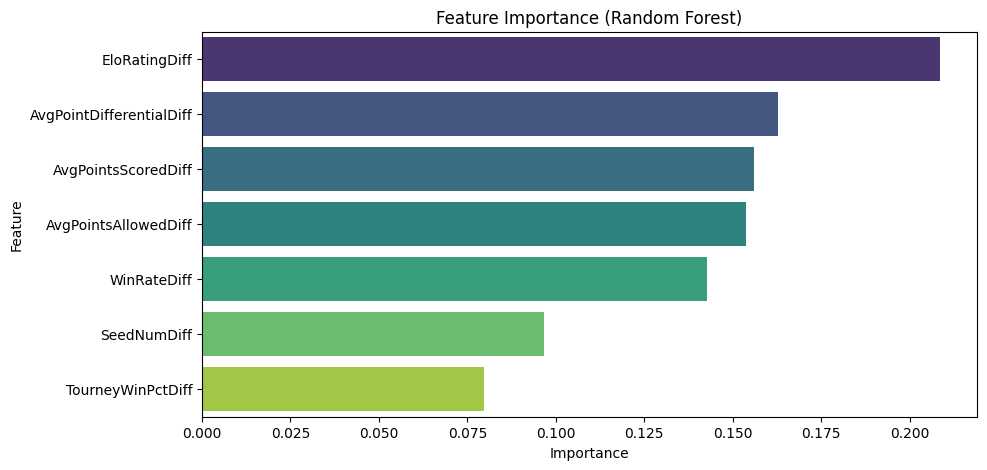

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns



# Define the features to normalize (excluding categorical features)
features_to_scale = ["SeedNumDiff", "WinRateDiff", "AvgPointDifferentialDiff",
                     "AvgPointsScoredDiff", "AvgPointsAllowedDiff", "EloRatingDiff", "TourneyWinPctDiff"]

scaler = StandardScaler()

# Apply normalization
df_scaled = final_features.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Define features and target
X = df_scaled.drop(columns=["Season", "TeamA", "TeamB" ,"Target"])  # Drop target column for training
y = df_scaled["Target"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance from the trained model
importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.show()



####**Permutation_importance**

<ipython-input-4-6bc43c0d8f2d>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df_op1, palette="viridis")


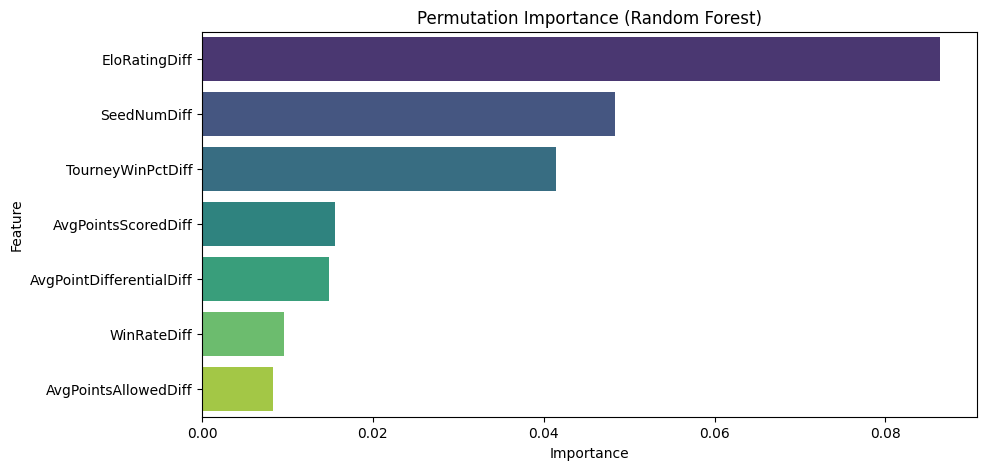

In [ ]:
from sklearn.inspection import permutation_importance

df_scaled_op1 = df_scaled.copy()

# Define features (X) and target (y)
X = df_scaled_op1.drop(columns=["Target", "TeamA", "TeamB", "Season"])

y = df_scaled_op1["Target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Compute permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Convert results into a DataFrame
importance_df_op1 = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df_op1, palette="viridis")
plt.title("Permutation Importance (Random Forest)")
plt.show()

In [ ]:
importance_df_op1

,Feature,Importance
5,EloRatingDiff,0.086404
0,SeedNumDiff,0.048392
6,TourneyWinPctDiff,0.041447
3,AvgPointsScoredDiff,0.015570
2,AvgPointDifferentialDiff,0.014912
1,WinRateDiff,0.009649
4,AvgPointsAllowedDiff,0.008333


# **Building, Training and Evaluating the Model**

##**Approach N°1 : Logistic Regression, RandomForest and xgboostClassifier**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, classification_report, roc_auc_score

data = df_scaled.copy()

X = data[['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
                    'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
                    'EloRatingDiff', 'TourneyWinPctDiff']]
y = data['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # Calculate Brier score
    brier_score = brier_score_loss(y_test, y_pred_prob)

    # Classification report
    class_report = classification_report(y_test, y_pred)

    # ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print(f"Model: {model_name}")
    print(f"Brier Score: {brier_score:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", class_report)
    print("===================================")


Model: Logistic Regression
Brier Score: 0.2500
ROC AUC Score: 0.5348
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50       651
           1       0.53      0.51      0.52       717

    accuracy                           0.51      1368
   macro avg       0.51      0.51      0.51      1368
weighted avg       0.51      0.51      0.51      1368

Model: Random Forest
Brier Score: 0.2304
ROC AUC Score: 0.6577
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       651
           1       0.64      0.60      0.62       717

    accuracy                           0.61      1368
   macro avg       0.61      0.61      0.61      1368
weighted avg       0.62      0.61      0.61      1368

Model: XGBoost
Brier Score: 0.2151
ROC AUC Score: 0.7193
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Logistic Regression does not have feature_importances_ attribute.


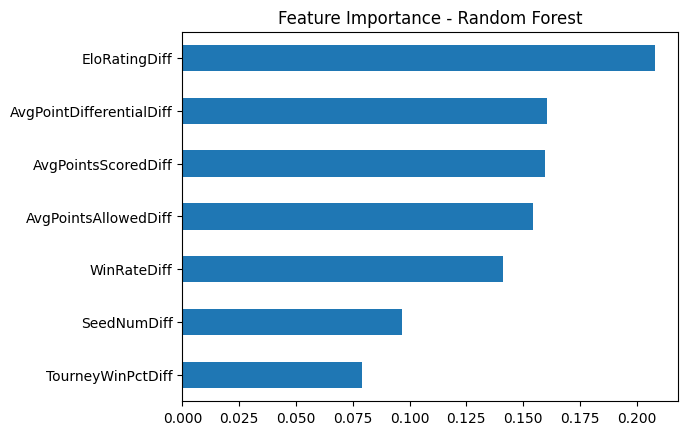

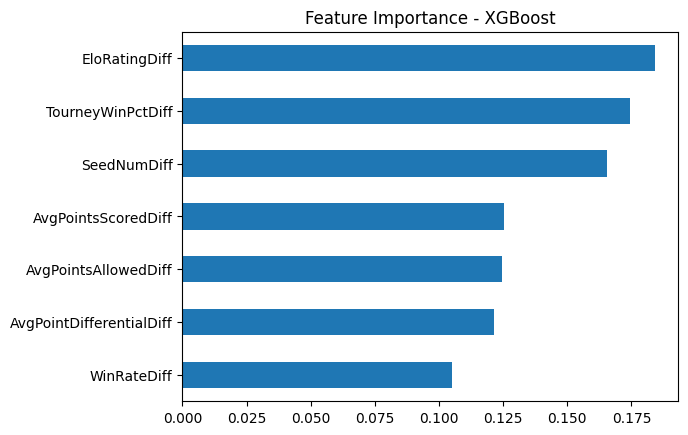

In [ ]:
X = pd.DataFrame(
    columns=['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
             'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
             'EloRatingDiff', 'TourneyWinPctDiff'])
feature_names = X.columns  # Define features_names here


for model_name, model in models.items():
    # Check if the model has the 'feature_importances_' attribute
    if hasattr(model, 'feature_importances_'):
        pd.Series(model.feature_importances_, index=feature_names).sort_values().plot(kind='barh', title=f'Feature Importance - {model_name}')
        plt.show()
    else:
        print(f"Model {model_name} does not have feature_importances_ attribute.")

##**Approach N°2: GridCv on xgboostClassifier**

###**Fine-tuning the XGBClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


X = data[['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
                    'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
                    'EloRatingDiff', 'TourneyWinPctDiff']]
y = data['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# XGBoost tuning
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

#xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                               param_grid=xgb_param_grid,
                               scoring='roc_auc',
                               cv=5,
                               verbose=1)

# Fit XGBoost
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

###**Scores of XGBClassifier**

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report, log_loss

y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_score = log_loss(y_test, y_pred_proba)
print(f"Model: XGBoost")
print(f"Brier Score: {brier:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_score:.4f}")
print(classification_report(y_test, y_pred))

Model: XGBoost
Brier Score: 0.3304
ROC AUC Score: 0.7313
Log Loss: 0.6161
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       651
           1       0.69      0.67      0.68       717

    accuracy                           0.67      1368
   macro avg       0.67      0.67      0.67      1368
weighted avg       0.67      0.67      0.67      1368



In [ ]:
import joblib

# Save the model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')


['best_xgb_model.pkl']

###**Features importance**

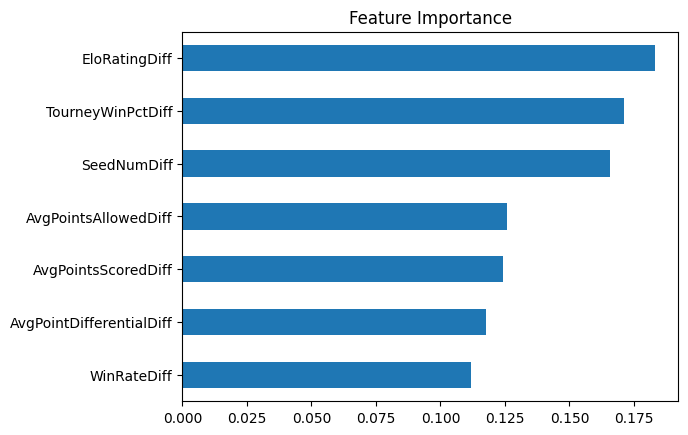

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame(
    columns=['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
             'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
             'EloRatingDiff', 'TourneyWinPctDiff'])
feature_names = X.columns  # Define features_names here

# Now you can use features_names
pd.Series(best_xgb_model.feature_importances_, index=feature_names).sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get feature names
X = pd.DataFrame(
    columns=['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
             'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
             'EloRatingDiff', 'TourneyWinPctDiff'])
feature_names = X.columns

# Create a DataFrame to store feature names and their importance
importance_df = pd.DataFrame({'Feature': feature_names,
                           'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Get the important features (e.g., top 3)
important_features = importance_df['Feature'].head(3).tolist()
important_features

['EloRatingDiff', 'TourneyWinPctDiff', 'SeedNumDiff']

## **Approach N°3: GridCv on RandomForest**

###**Fine-tuning the RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report

data = df_scaled.copy()

X = data[['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
                    'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
                    'EloRatingDiff', 'TourneyWinPctDiff']]
y = data['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              scoring='roc_auc',
                              cv=5,
                              verbose=1)

# Fit Random Forest
rf_grid_search.fit(X, y)
best_rf_model = rf_grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


###**Scores of RandomForest**

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report, log_loss

y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_score = log_loss(y_test, y_pred_proba)
print(f"Model: RandomForest")
print(f"Brier Score: {brier:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_score:.4f}")
print(classification_report(y_test, y_pred))

Model: RandomForest
Brier Score: 0.2098
ROC AUC Score: 0.8763
Log Loss: 0.5712
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       651
           1       0.79      0.82      0.80       717

    accuracy                           0.79      1368
   macro avg       0.79      0.79      0.79      1368
weighted avg       0.79      0.79      0.79      1368



###**Features importance**

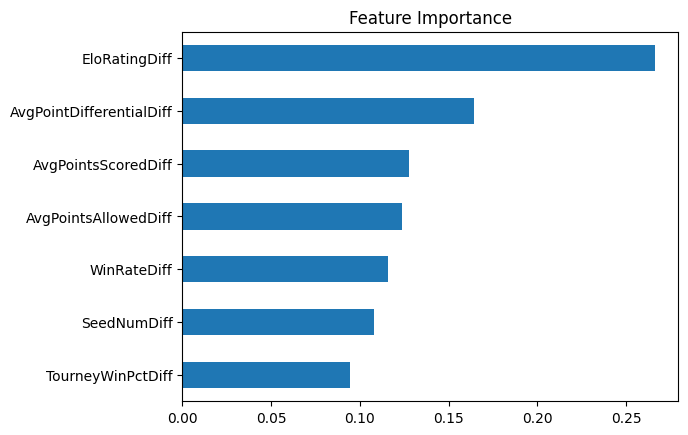

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame(
    columns=['SeedNumDiff', 'WinRateDiff', 'AvgPointDifferentialDiff',
             'AvgPointsScoredDiff', 'AvgPointsAllowedDiff',
             'EloRatingDiff', 'TourneyWinPctDiff'])
feature_names = X.columns  # Define features_names here

# Now you can use features_names
pd.Series(best_rf_model.feature_importances_, index=feature_names).sort_values().plot(kind='barh', title='Feature Importance')
plt.show()